# Demo of the pipeline to get a cleaned image
* Data from this [Google Drive link](https://drive.google.com/drive/folders/1N71DLpGBLPwUSbkZ3tYmOyuOWJbS4_Kj?usp=drive_link)

In [10]:
import sys
sys.path.append("../")
import numpy as np
from pixsed.photometry_tools import Image, Atlas
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read the Image.
img = Image('data/NGC5194_SDSS_r.fits', coord_sky=('13h29m52.698s', '+47d11m42.93s'))

### Analyze the background

CPU times: user 19.4 s, sys: 4.86 s, total: 24.3 s
Wall time: 24.6 s


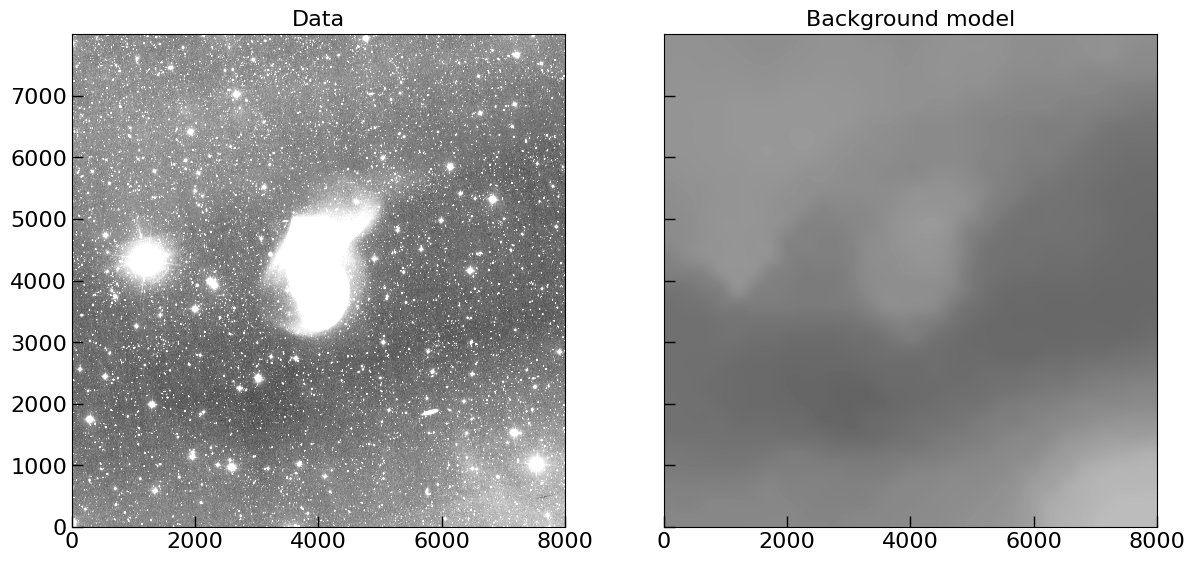

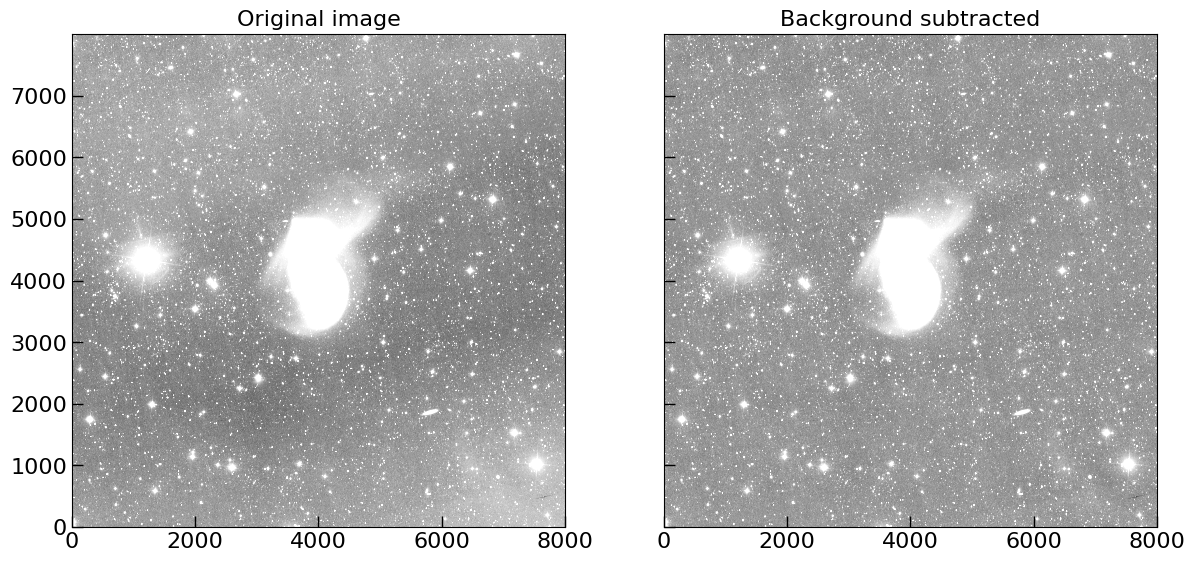

In [3]:
%%time

img.background_properties(mask_type='quick', sigma=3, maxiters=5, f_sample=0.01)
threshold = img._bkg_std
img.gen_mask_background(threshold, kernel_fwhm=10, expand_factor=1.5, plot=False, 
                        norm_kwargs=dict(percent=90, stretch='asinh', asinh_a=0.5),
                        interactive=False)

# It is important not to use a very small box_size!
box_size = img._data.shape[0] // 30
img.gen_model_background(box_size=box_size, filter_size=5, plot=True, norm_kwargs=dict(percent=80, asinh_a=0.1))
img.background_subtract(plot=True, norm_kwargs=dict(percent=90, stretch='asinh', asinh_a=0.5))

### Analyze the sources in the image

CPU times: user 25 s, sys: 7.57 s, total: 32.5 s
Wall time: 31.7 s


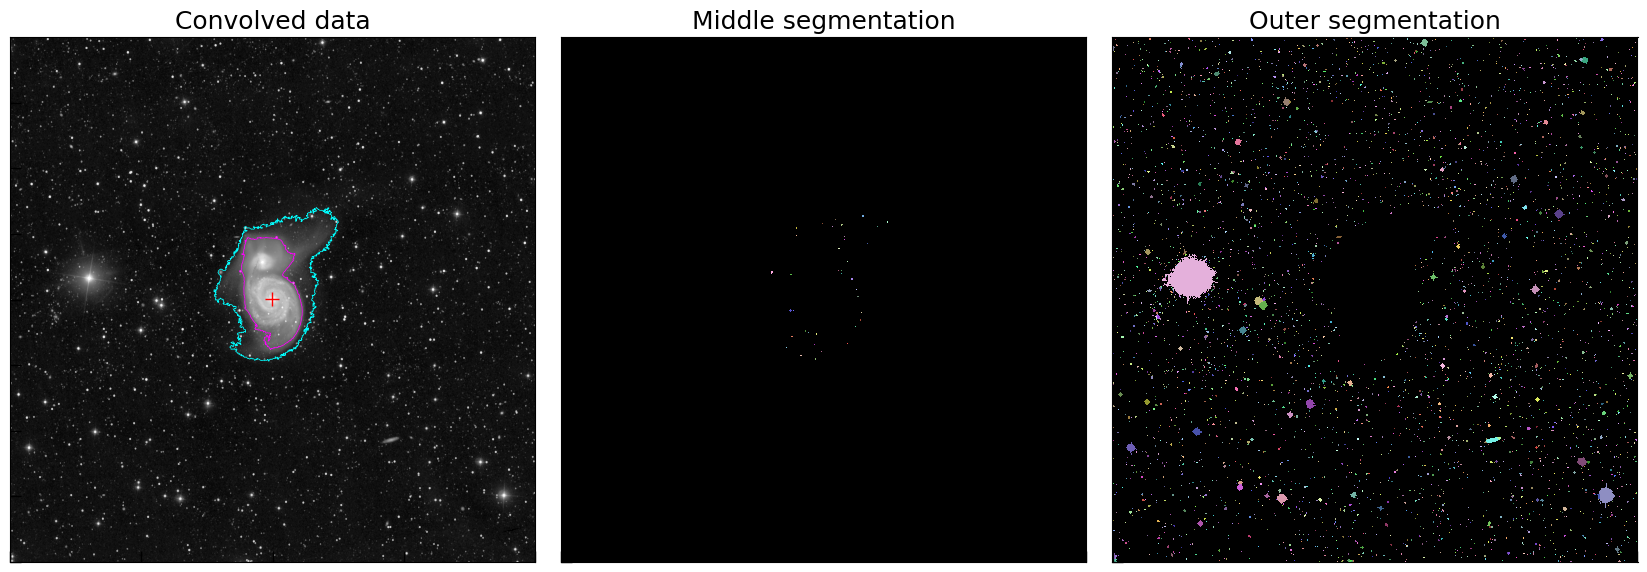

In [4]:
%%time

# Update the background statistics
img.background_properties(mask_type='subbkg', f_sample=0.01)

# Get the target region
threshold = 0.5 * img._bkg_std
img.gen_target_mask(threshold, kernel_fwhm=10, npixels=5, expand_factor=1, plot=False, 
                    norm_kwargs=dict(percent=99.99, stretch='asinh', asinh_a=0.001),
                    interactive=False)

# Analyze all the sources in the image
threshold_i = 5 * img._bkg_std
threshold_o = 1 * img._bkg_std
img.detect_source_extended(threshold_i=threshold_i, threshold_o=threshold_o, plot=True, interactive=False)

### Analyze the PSF
* One can choose to skip this step and manually set a FWHM of the PSF

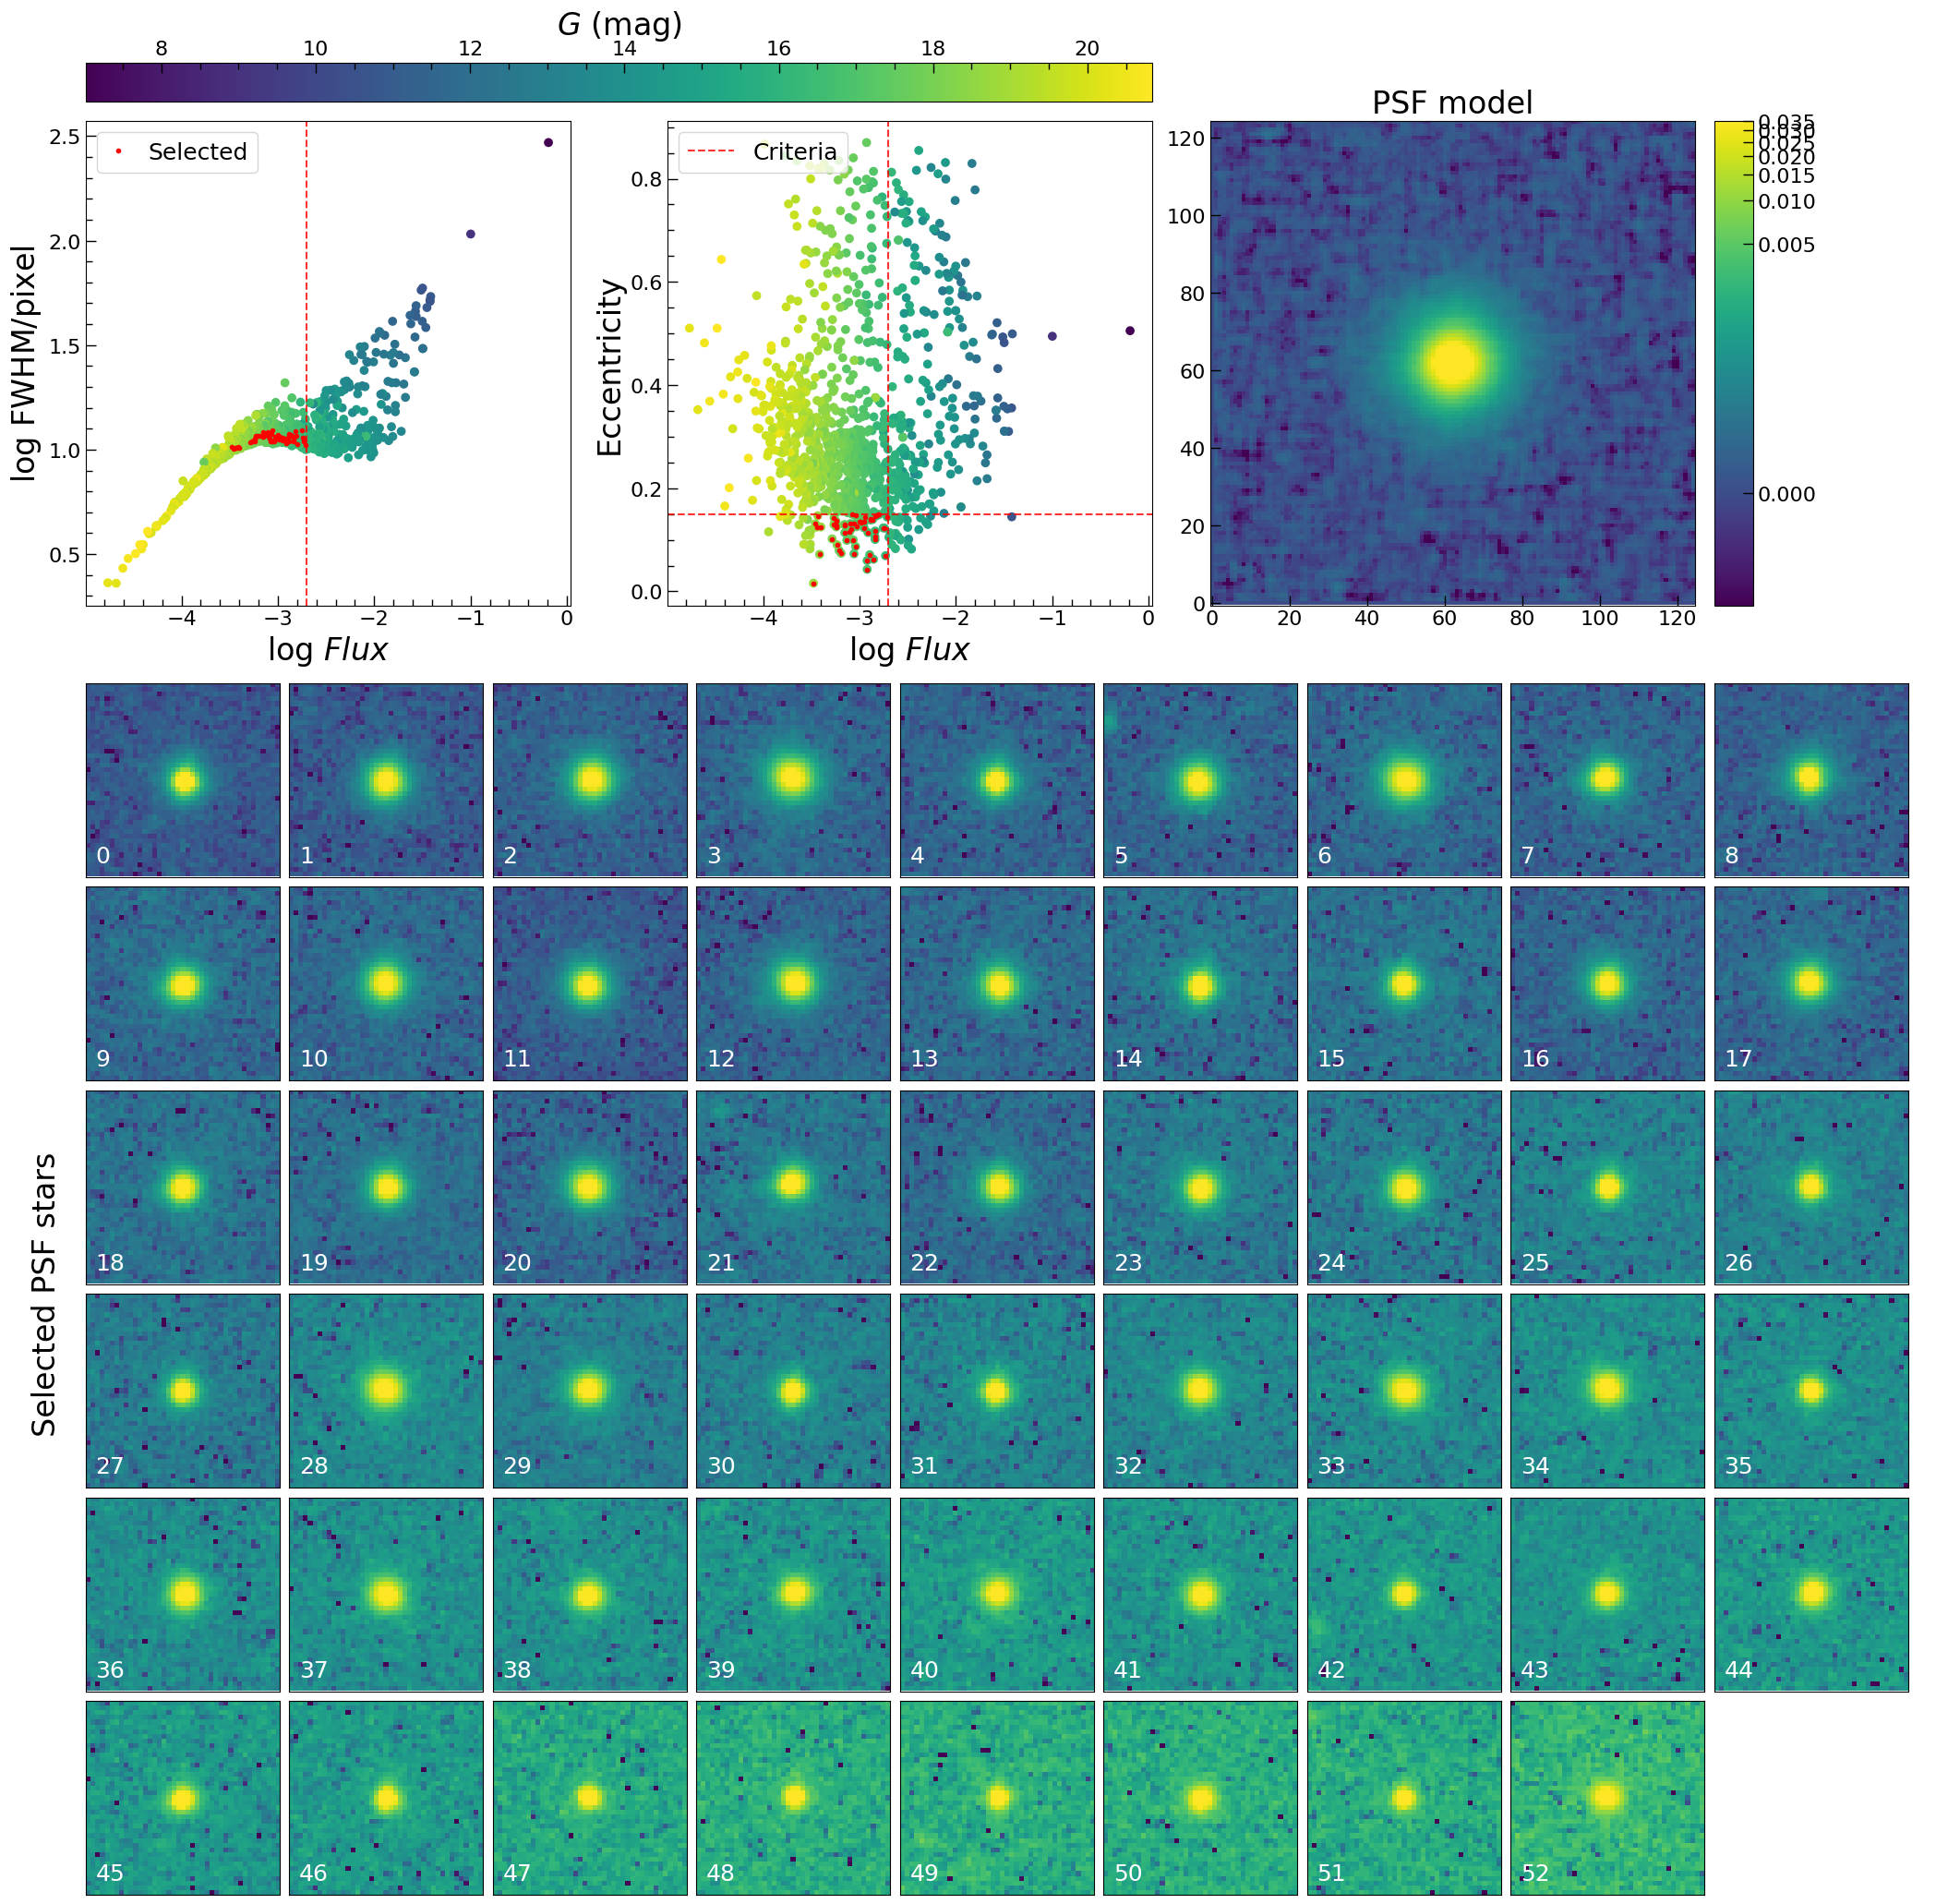

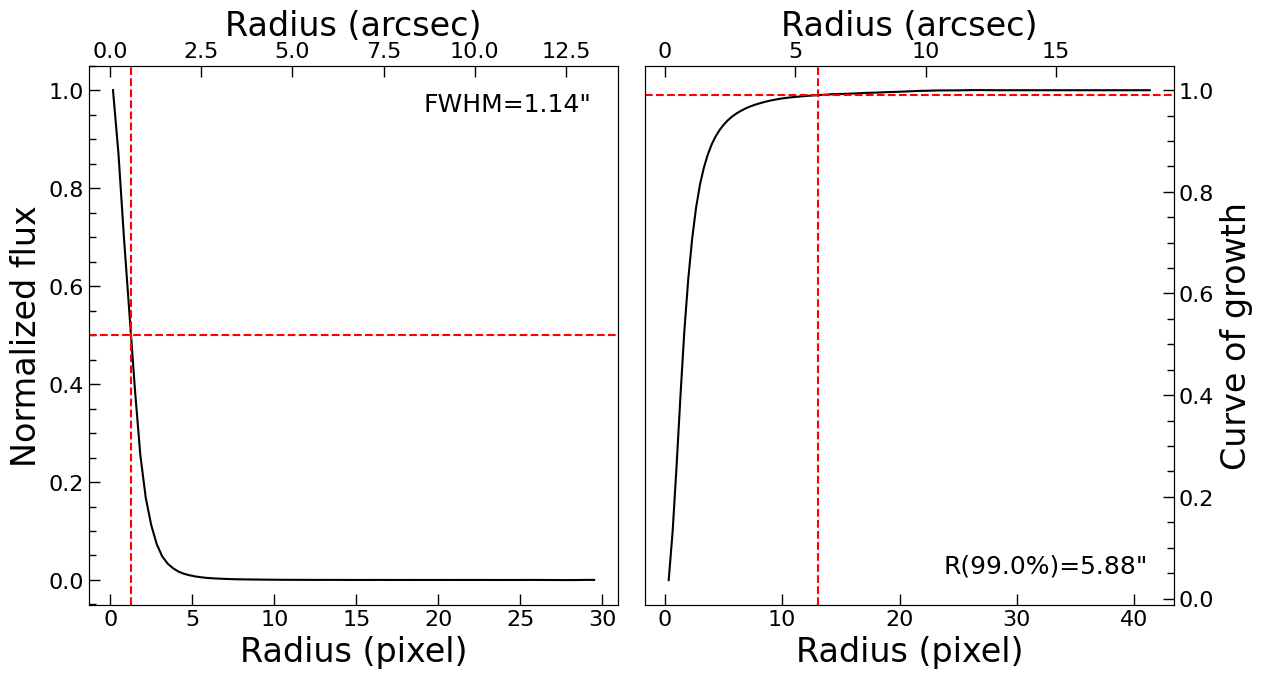

CPU times: user 11.8 s, sys: 1.88 s, total: 13.7 s
Wall time: 16.4 s


In [5]:
%%time 

img.gen_psf_model(extract_size=41, threshold_flux=0.002, threshold_fwhm=20, threshold_eccentricity=0.15, oversampling=3, 
                  smoothing_kernel='quadratic', num_lim=54, skip_psf_model=False, 
                  plot=True)
plt.show()

img.get_psf_profile(enclosed_energy=0.99, plot=True)
plt.show()

### Generate the mask for the image

Found 41 stars!


41it [00:15,  2.69it/s]


Found 30 masks!


100%|██████████| 30/30 [00:00<00:00, 2571.77it/s]


Found 30 masks!


100%|██████████| 30/30 [00:00<00:00, 2797.45it/s]


CPU times: user 21.2 s, sys: 12.8 s, total: 34 s
Wall time: 37.7 s


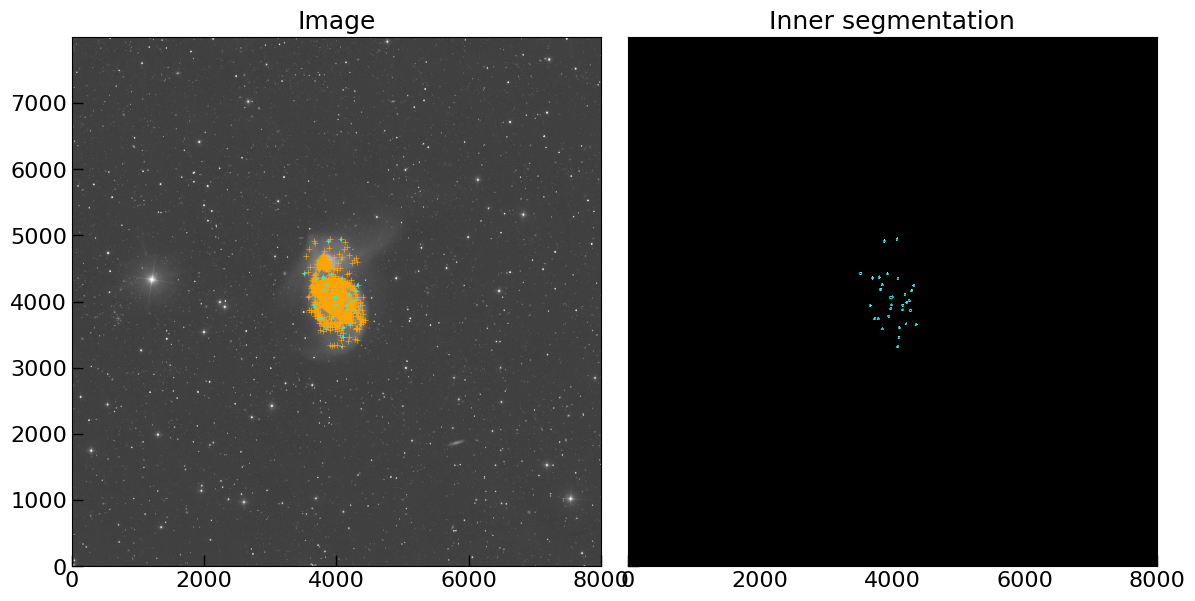

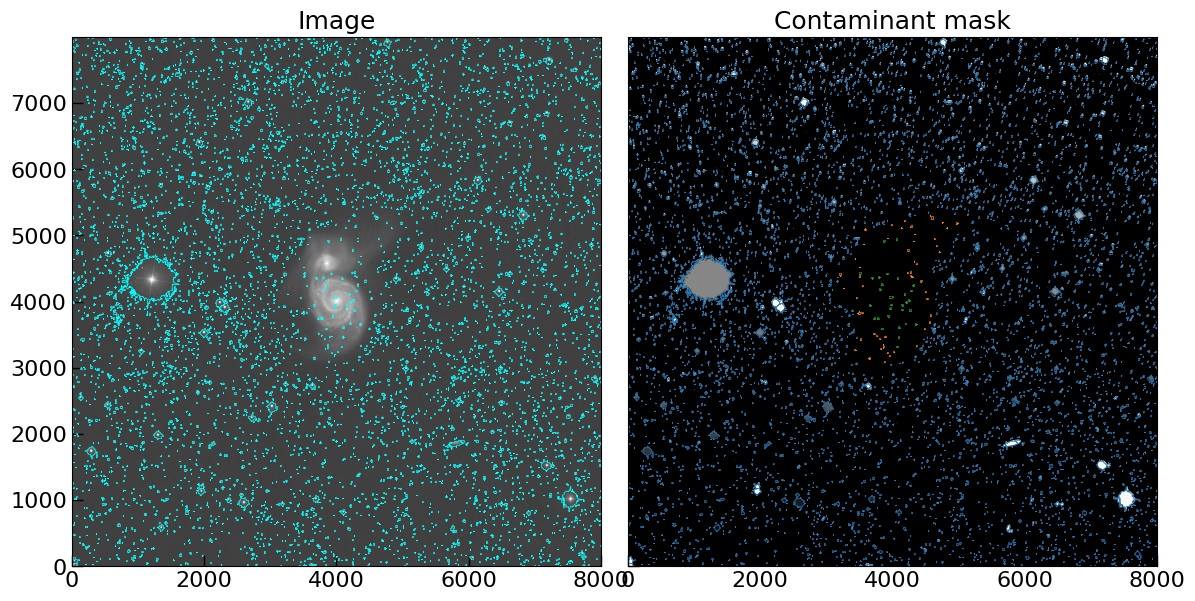

In [6]:
%%time

#img.gen_mask_overlap(detect_thres=10.0, threshold_gmag=20, plot=False, 
#                     interactive=False, verbose=True)
#img.gen_mask_surround(expand_factor=1.5, plot=False)
#img.gen_mask_contaminant(plot=True, interactive=False)

img.gen_segment_inner(detect_thres=10.0, threshold_gmag=20, plot=True, 
                      interactive=False, verbose=True)
img.gen_mask_contaminant(expand_inner=1, expand_edge=2, expand_outer=2., plot=True, interactive=False)

### Refine the segment of the overlapped sources
* One can decide whether to go through this step to improve the segmentations and masks

In [12]:
box_size = 1
img.gen_model_galaxy(box_size=box_size, filter_size=3, plot=True, interactive=False)
plt.show()

threshold_i = 5 * img._bkg_std
threshold_e = 3 * img._bkg_std
img.refine_segment_overlap(threshold_i=threshold_i, threshold_e=threshold_e, 
                           kernel_fwhm_i=1, kernel_fwhm_e=1 , threshold_gmag=20, 
                           plot=True, interactive=False)
img.gen_mask_contaminant(expand_inner=1, expand_edge=2, expand_outer=2, plot=True, interactive=False)

KeyboardInterrupt: 

### Generate the galaxy model and clean the image

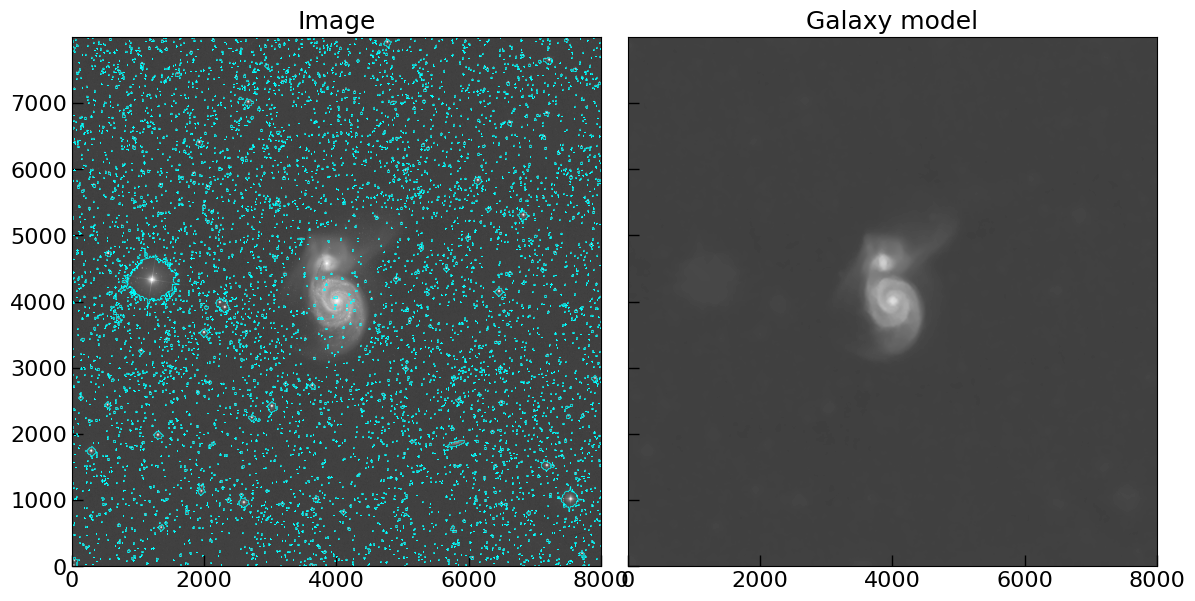

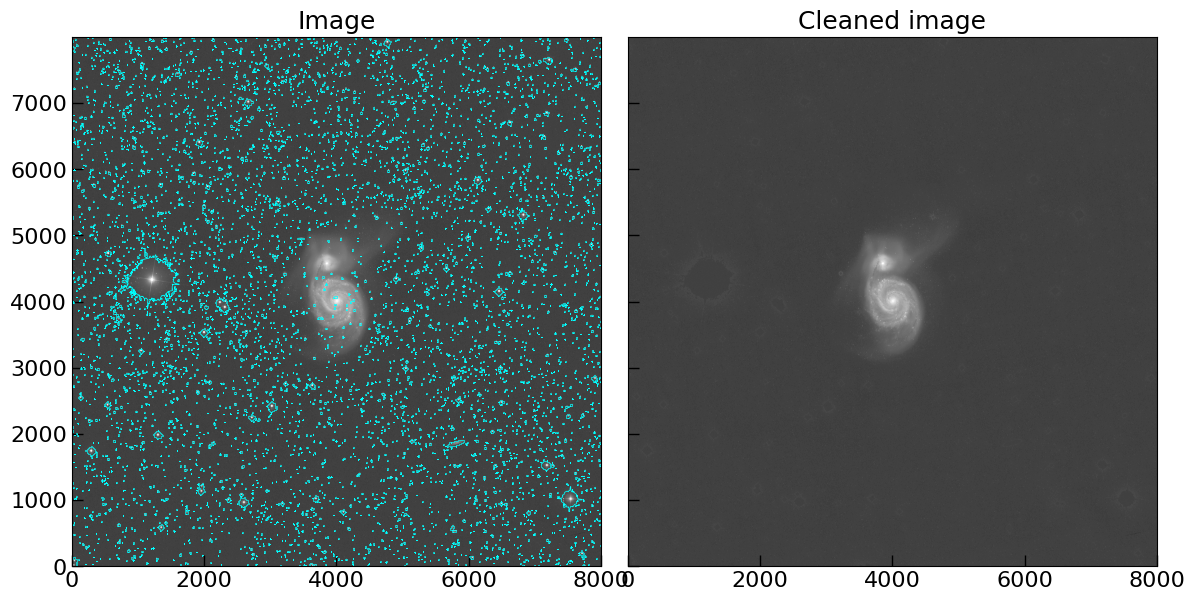

In [8]:
box_size = (int(img._psf_fwhm_pix), int(img._psf_fwhm_pix))
img.gen_model_galaxy(box_size=None, filter_size=3, plot=True, interactive=False)
plt.show()


img.gen_image_clean(plot=True, norm_kwargs=dict(percent=99.99, stretch='asinh', asinh_a=0.001), interactive=False)
plt.show()

In [9]:
img.save('data/NGC5194_SDSS_r_clean.fits', overwrite=True)